In [ ]:
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt

from mtj.init import init_m
from mtj.llg_heun import LLG_Heun
from mtj.constants import VACUUM_PERMEABILITY

### Demonstration of Magnetization Dynamics (Precession)

In this notebook, we showcase our computation of magnetization dynamics by trying to reproduce an example from [O. Fruchart's lecture notes on nanomagnetism](https://fruchart.eu/olivier/publications/index.html) (2018, p. 150). In this demonstration, we perform the simulations on a thin film of soft magnetic material (Permalloy), with 
$$
M_s\approx1 \text{ T} = 1\text{ T} /\mu_0 \approx 7.9 \cdot 10^{5} \text{ A/m},
$$
$\mu_0$ being the vacuum magnetic permeability. For a thin film, we approximate the demagnetization tensor to have diagnoal elements $N_{xx}=N_{yy} = 0$ and $N_{zz}=1$.

**Physical Constants Used**

| Constant | Symbol | Value | Unit | Description |
|----------|--------|-------|------|-------------|
| Saturation magnetization (Permalloy) | $M_s$ | $7.9 \cdot 10^{5}$ | A/m | Typical for Permalloy |
| Magnetocrystalline anisotropy constant | $K_u$ | $0.02 \cdot 7.9 \cdot 10^{5}$ | J/m³ |  |
| Time step | $\Delta t$ | $10^{-13}$ | s | Simulation time step |
| Damping factor | $\alpha$ | 0 | (unitless) | **No damping** |

In [2]:
Ms = 1 / VACUUM_PERMEABILITY

We choose initial magnetization almost parallell to $\hat{x}$, with a bit of noise.

In [3]:
m0_init = np.array([1,0.001,0.001])
m0 = m0_init / np.linalg.norm(m0_init)
print(m0)

[0.999999 0.001    0.001   ]


We define some helper functions to iterate over the defined time series and help with plotting.

In [4]:
def calculate_magnetization(
    H_app: npt.NDArray[np.float64],
    m0=m0,  # Initial magnetization (is normalized before simulation)
    Tn=2e-9,  # (s)
    dt=1e-13,  # time step (s)
    alpha=0,  # No damping
    K_u=0.02 * Ms,  # Crystal anisotropy constant
    M_s=Ms,  # NiFe permalloy (A/m)
    u_k=np.array([1, 0, 0]),  # In-plane magnetocrystalline anisotropy along x-axis
    N=np.diag([0, 0, 1]),  # "Infinite" thin film
    T=0,  # Temperature (K), no thermal fluctuations in this example
    Vol=1e-9 * 25e-9**2 * np.pi,  # Volume, only used in case of thermal fluctuations
    p=np.zeros(3),
    V=0,
):
    time_series = np.arange(0, Tn, dt)
    m = init_m(m0, len(time_series))

    for i, t in enumerate(time_series[:-1]):
        # Calculate the magnetization for the next time step
        m[i + 1] = LLG_Heun(
            m_i=m[i],
            T=T,
            Vol=Vol,
            dt=dt,
            alpha=alpha,
            H_app=H_app,
            M_s=M_s,
            K_u=K_u,
            u_k=u_k,
            N=N,
            p=p,
            a_para=1e4,
            a_ortho=1e4,
            V=V,
        )

    return m, time_series

In [5]:
def plot_unit_sphere(ax, m, label, title):
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = np.outer(np.cos(u), np.sin(v))
    y = np.outer(np.sin(u), np.sin(v))
    z = np.outer(np.ones(np.size(u)), np.cos(v))

    ax.plot_surface(x, y, z, color='lightgray', alpha=0.2, rstride=10, cstride=10)
    ax.plot(m[:, 0], m[:, 1], m[:, 2], label=label, lw=1)

    ax.set_xlabel(r"$m_x$")
    ax.set_ylabel(r"$m_y$")
    ax.set_zlabel(r"$m_z$")
    ax.set_title(f"{title}")
    ax.set_box_aspect([1, 1, 1])
    if label:
        ax.legend()

We compute the magnetization trajectories with different magnitudes of the applied field.

In [6]:
m1, _ = calculate_magnetization(
    H_app=np.array([0, -0.04*Ms,0]),
    )
m2, _ = calculate_magnetization(
    H_app=np.array([0, -0.0201*Ms,0]),
    )
m3, _ = calculate_magnetization(
    H_app=np.array([0, -0.019*Ms,0]),
    )
m4, _ = calculate_magnetization(
    m0=-m0,
    H_app=np.array([0, -0.019*Ms,0]),
    )

We observe that for $H_{app} < \frac{H_k}{2},$ the trajectories do not cross the $m_x=0$ plane, but increasing the magnitude of the applied field above the threshold enables switching.

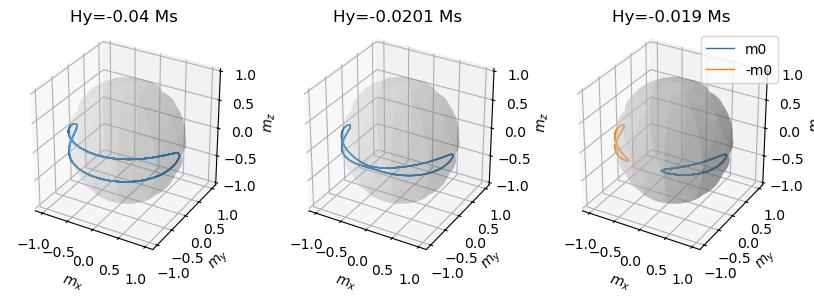

In [7]:
fig, ax = plt.subplots(1, 3, figsize=(10, 7), subplot_kw={"projection": "3d"})
plot_unit_sphere(ax[0], m1, "","Hy=-0.04 Ms")
plot_unit_sphere(ax[1], m2, "","Hy=-0.0201 Ms")
plot_unit_sphere(ax[2], m3, "m0","Hy=-0.019 Ms")
plot_unit_sphere(ax[2], m4, "-m0","Hy=-0.019 Ms")